In [76]:
import pandas as pd
df = pd.read_csv("train.tsv", sep='\t')
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [77]:
df.shape

(156060, 4)

In [78]:
import numpy as np
seq_len = 512
num_samples = len(df)

Xids = np.zeros((num_samples,seq_len))
Xmask = np.zeros((num_samples,seq_len))

Xids.shape

(156060, 512)

In [79]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
for i , phrase in enumerate(df['Phrase']):
  tokens = tokenizer.encode_plus(phrase,
                                 max_length=seq_len,
                                 truncation=True,
                                 padding='max_length',
                                 add_special_tokens=True
                                 )
  Xids[i,:]=tokens['input_ids']
  Xmask[i,:]=tokens['attention_mask']

In [80]:
Xids

array([[  101.,   138.,  1326., ...,     0.,     0.,     0.],
       [  101.,   138.,  1326., ...,     0.,     0.,     0.],
       [  101.,   138.,  1326., ...,     0.,     0.,     0.],
       ...,
       [  101.,   170., 25247., ...,     0.,     0.,     0.],
       [  101.,   170., 25247., ...,     0.,     0.,     0.],
       [  101., 22572., 12148., ...,     0.,     0.,     0.]])

In [81]:
Xmask

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [82]:
arr = df['Sentiment'].values
arr

array([1, 2, 2, ..., 3, 2, 2])

In [83]:
labels = np.zeros((num_samples,arr.max()+1))
labels.shape

(156060, 5)

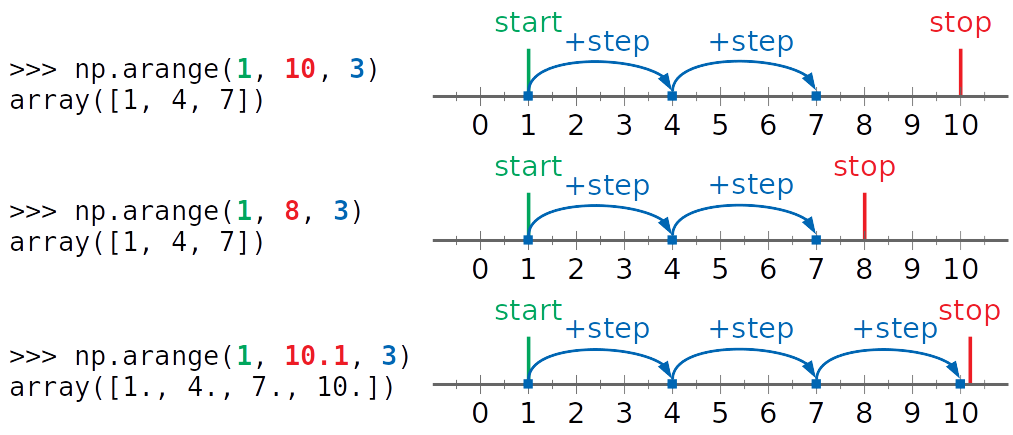

In [84]:
np.arange(num_samples),arr

(array([     0,      1,      2, ..., 156057, 156058, 156059]),
 array([1, 2, 2, ..., 3, 2, 2]))

In [85]:
labels[np.arange(num_samples),arr]

array([0., 0., 0., ..., 0., 0., 0.])

In [86]:
labels[np.arange(num_samples),arr]=1
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [87]:
#With the help of tf.data.Dataset.from_tensor_slices() method,
#we can get the slices of an array in the form of objects by using tf.data.Dataset.from_tensor_slices() method.
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((Xids,Xmask,labels))
dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(512,), dtype=tf.float64, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [88]:
labels[0,:].shape

(5,)

In [89]:
def map_fun(input_ids,masks,labels):
  return {'input_ids':input_ids,'attention_mask':masks}, labels

In [90]:
dataset = dataset.map(map_fun)

In [91]:
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(512,), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(512,), dtype=tf.float64, name=None)}, TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [92]:
batch_size =4
dataset = dataset.shuffle(10000).batch(batch_size,drop_remainder=True)
dataset.take(1)

<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(4, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(4, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(4, 5), dtype=tf.float64, name=None))>

In [93]:
split = 0.9
size = int((num_samples/batch_size)*split)
size

35113

In [94]:
train_ds =dataset.take(size)
val_ds = dataset.skip(size)

del dataset

In [95]:
train_ds, val_ds

(<_TakeDataset element_spec=({'input_ids': TensorSpec(shape=(4, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(4, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(4, 5), dtype=tf.float64, name=None))>,
 <_SkipDataset element_spec=({'input_ids': TensorSpec(shape=(4, 512), dtype=tf.float64, name=None), 'attention_mask': TensorSpec(shape=(4, 512), dtype=tf.float64, name=None)}, TensorSpec(shape=(4, 5), dtype=tf.float64, name=None))>)

In [96]:
from transformers import TFAutoModel
bert = TFAutoModel.from_pretrained('bert-base-uncased')

bert.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "tf_bert_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109482240 (417.64 MB)
Trainable params: 109482240 (417.64 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [97]:
input_ids = tf.keras.layers.Input(shape=(seq_len),name='input_ids',dtype='int32')
mask = tf.keras.layers.Input(shape=(seq_len),name='attention_mask',dtype='int32')

embeddings=bert.bert(input_ids,attention_mask=mask)[1]

x=tf.keras.layers.Dense(1024,activation='relu')(embeddings)
y=tf.keras.layers.Dense(arr.max()+1,activation='softmax',name='outputs')(x)


In [98]:
model = tf.keras.Model(inputs=[input_ids,mask],outputs=y)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, 512)]                0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, 512)]                0         []                            
 )                                                                                                
                                                                                                  
 bert (TFBertMainLayer)      TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
                             ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, 512, 7                                     

In [99]:
epochs = 50
learning_rate = 0.00001
decay_rate = learning_rate / epochs

optimizer =tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss= tf.keras.losses.CategoricalCrossentropy()
acc=tf.keras.metrics.CategoricalAccuracy('accuracy')

In [100]:
model.compile(optimizer=optimizer,loss=loss,metrics=[acc])

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1,
    verbose=1
)

13734/35113 [==========>...................] - ETA: 2:44:41 - loss: 1.0706 - accuracy: 0.5754

In [ ]:
model.save('sentiment_model')

In [ ]:
import tensorflow as tf

In [ ]:
model = tf.keras.models.load_model('sentiment_model')

In [ ]:
model.summary()

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
  tokens = tokenizer.encode_plus(text,
                                 max_length=seq_len,
                                 truncation=True,
                                 padding='max_length',
                                 add_special_tokens=True,
                                 return_token_type_id=False,
                                 return_tensors='tf'
                                 )
  return {
      'input_ids':tf.cast(tokens['input_ids'], tf.float64),
      'attention_mask': tf.cast(tokens['attention_mask']. tf.float64)
  }

In [ ]:
test = prep_data('hi i am going to school')

In [ ]:
probs = model.predict(test)
probs[0]

In [ ]:
import numpy as np
np.argmax(probs[0])